In [1]:
import pandas as pd
import numpy as np
import librosa 

import seaborn as sn
import matplotlib.pyplot as plt
import IPython.display as ipd #palying audio
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import os
import csv
import soundfile
import sklearn
from matplotlib.colors import Normalize
import glob
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate
import pickle
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
path = os.chdir('C:/Users/makye/OneDrive/Documents/Career/BeCode/study/Data_preprocessing/audioProcessing/pump')
print(os.getcwd())

C:\Users\makye\OneDrive\Documents\Career\BeCode\study\Data_preprocessing\audioProcessing\pump


In [4]:
# load dataset

def loadData():
    
    #Pulling the data
    path = 'martin_pump40.csv'
    df = pd.read_csv(path)
    return df

df = loadData()
df


,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,target
0,0.683818,0.108170,1.0,0.190720,0.679056,0.010531,7.151322e-17,0.466670,0.021297,0.004169,...,0.204830,-0.369489,-2.238656,4.716025,-4.255774,3.338483,-3.896483,5.041117,-1.407492,0
1,0.583996,0.129650,1.0,0.220414,0.546216,0.021984,1.201486e-16,1.294522,0.072030,0.001337,...,-2.292946,1.141588,-2.991373,4.649738,-4.002141,3.838974,-4.009880,2.825847,1.075340,0
2,0.645543,0.094941,1.0,0.204511,0.633333,0.023768,1.320205e-16,2.386425,0.078395,0.001977,...,-0.069810,2.970889,-2.798779,6.113424,-1.600979,4.438368,-1.818079,1.918840,-0.818630,0
3,0.334817,0.014604,1.0,0.279246,0.241708,0.021464,1.160403e-16,2.258773,0.092336,0.001330,...,-11.222979,-4.693631,-4.585680,6.185575,-0.899375,6.875870,-1.772375,3.351006,-3.978265,0
4,0.363110,0.027821,1.0,0.277294,0.258746,0.019026,1.150735e-16,1.738417,0.055788,0.001415,...,1.522294,-4.421966,-11.739436,-1.185205,-5.009368,7.183607,-0.421902,2.827000,-1.914379,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12610,0.520409,0.044676,1.0,0.253924,0.482333,0.003355,1.884953e-17,0.307427,0.010153,0.000038,...,-1.102791,0.425305,-3.573908,1.377608,-9.326706,-6.191280,-11.942490,-6.865319,-6.605413,1
12611,0.521859,0.082061,1.0,0.242351,0.470752,0.003022,1.396323e-17,0.123734,0.007071,0.000066,...,6.101332,5.055927,-3.092504,2.578304,-8.390204,-4.064268,-6.515065,2.032784,-5.071927,1
12612,0.499682,0.068543,1.0,0.260848,0.443785,0.003211,1.794031e-17,0.151006,0.007746,0.000069,...,-1.248067,2.794472,-0.614687,4.316348,-3.785549,-1.836788,-5.867575,-4.305118,-3.327899,1
12613,0.483045,0.072764,1.0,0.254647,0.415853,0.003286,1.686015e-17,0.127506,0.008191,0.000074,...,-1.018300,3.153202,-1.612237,3.861713,-5.186883,-2.197448,-5.732657,-3.224555,-2.162239,1


In [5]:
#Creating header for features
header = ''

variables = ['chroma_stft', 'mel_spec',  'rms_f',  'spec_cent', 'spec_bw', 'rolloff', 'zcrf']

for i in variables:
    
    header += f' mean_{i}'
    header += f' min_{i}'
    header += f' max_{i}'
    header += f' std_{i}'
    header += f' median_{i}'
    
for i in range(1, 41):
    header += f' mean_mfcc{i}'
        
for i in range(1, 41):
    header += f' min_mfcc{i}'
        
for i in range(1, 41):
    header += f' max_mfcc{i}'
        
for i in range(1, 41):
    header += f' std_mfcc{i}'
        
for i in range(1, 41):
    header += f' median_mfcc{i}'
    
header = header.split()

In [6]:
# Adding header to features

features = df.iloc[:, :-1] #Selecting features
features.columns = header # Adding header to features
features

,mean_chroma_stft,min_chroma_stft,max_chroma_stft,std_chroma_stft,median_chroma_stft,mean_mel_spec,min_mel_spec,max_mel_spec,std_mel_spec,median_mel_spec,...,median_mfcc31,median_mfcc32,median_mfcc33,median_mfcc34,median_mfcc35,median_mfcc36,median_mfcc37,median_mfcc38,median_mfcc39,median_mfcc40
0,0.683818,0.108170,1.0,0.190720,0.679056,0.010531,7.151322e-17,0.466670,0.021297,0.004169,...,-0.124755,0.204830,-0.369489,-2.238656,4.716025,-4.255774,3.338483,-3.896483,5.041117,-1.407492
1,0.583996,0.129650,1.0,0.220414,0.546216,0.021984,1.201486e-16,1.294522,0.072030,0.001337,...,0.562411,-2.292946,1.141588,-2.991373,4.649738,-4.002141,3.838974,-4.009880,2.825847,1.075340
2,0.645543,0.094941,1.0,0.204511,0.633333,0.023768,1.320205e-16,2.386425,0.078395,0.001977,...,0.208499,-0.069810,2.970889,-2.798779,6.113424,-1.600979,4.438368,-1.818079,1.918840,-0.818630
3,0.334817,0.014604,1.0,0.279246,0.241708,0.021464,1.160403e-16,2.258773,0.092336,0.001330,...,-8.809001,-11.222979,-4.693631,-4.585680,6.185575,-0.899375,6.875870,-1.772375,3.351006,-3.978265
4,0.363110,0.027821,1.0,0.277294,0.258746,0.019026,1.150735e-16,1.738417,0.055788,0.001415,...,8.073055,1.522294,-4.421966,-11.739436,-1.185205,-5.009368,7.183607,-0.421902,2.827000,-1.914379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12610,0.520409,0.044676,1.0,0.253924,0.482333,0.003355,1.884953e-17,0.307427,0.010153,0.000038,...,2.902631,-1.102791,0.425305,-3.573908,1.377608,-9.326706,-6.191280,-11.942490,-6.865319,-6.605413
12611,0.521859,0.082061,1.0,0.242351,0.470752,0.003022,1.396323e-17,0.123734,0.007071,0.000066,...,4.538052,6.101332,5.055927,-3.092504,2.578304,-8.390204,-4.064268,-6.515065,2.032784,-5.071927
12612,0.499682,0.068543,1.0,0.260848,0.443785,0.003211,1.794031e-17,0.151006,0.007746,0.000069,...,3.497271,-1.248067,2.794472,-0.614687,4.316348,-3.785549,-1.836788,-5.867575,-4.305118,-3.327899
12613,0.483045,0.072764,1.0,0.254647,0.415853,0.003286,1.686015e-17,0.127506,0.008191,0.000074,...,2.629176,-1.018300,3.153202,-1.612237,3.861713,-5.186883,-2.197448,-5.732657,-3.224555,-2.162239


In [7]:
#defining features and target/scaling

X = features
y = df.iloc[:, -1]

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
X_minmax = scaler.fit_transform(X)


In [8]:
############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [9]:
#Unscaled:

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train, y_train) #Unscaled train
    score = model.score(X_test, y_test) #unscaled test
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

C:\Users\makye\anaconda3\envs\AudioProcessing\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
4,RandomForestClassifier,97.42%
7,QuadraticDiscriminantAnalysis,96.71%
1,SVC,95.88%
5,AdaBoostClassifier,95.80%
3,DecisionTreeClassifier,94.61%
0,KNeighborsClassifier,93.58%
2,SVC RBF kernel,89.30%
6,GaussianNB,85.41%


In [10]:
#Scaled
classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train) #scaled train
    score = model.score(X_test_scaled, y_test) #Scaled test
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

C:\Users\makye\anaconda3\envs\AudioProcessing\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
2,SVC RBF kernel,98.26%
0,KNeighborsClassifier,97.74%
4,RandomForestClassifier,97.23%
7,QuadraticDiscriminantAnalysis,96.91%
1,SVC,96.39%
5,AdaBoostClassifier,95.80%
3,DecisionTreeClassifier,94.45%
6,GaussianNB,84.26%


In [21]:
#RandomForest Classifier (Scaled features)
classifier = RandomForestClassifier(random_state=42, n_estimators=150)
# classifier  = SVC()
classifier.fit(X_train_scaled, y_train) #scaled train
# score = model.score(X_test_scaled, y_test)
y_pred = classifier.predict(X_test_scaled)

In [22]:
def Metrics(y_test, y_pred):
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    
Metrics(y_test, y_pred)

[[2252    1]
 [  66  204]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2253
           1       1.00      0.76      0.86       270

    accuracy                           0.97      2523
   macro avg       0.98      0.88      0.92      2523
weighted avg       0.97      0.97      0.97      2523

0.9734443123265953


Text(69.0, 0.5, 'True Values')

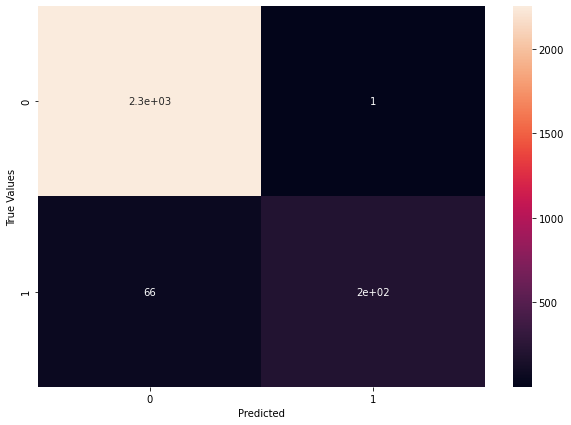

In [23]:
#Plotting confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('True Values')

In [82]:
#Cross Validation????
cv = cross_validate(classifier, X_scaled, y, cv=5)
print(cv['test_score'])
print(cv['test_score'].mean())

[0.47496947 0.86853887 0.96091205 0.9784202  0.95969055]
0.8485062289622551


In [24]:
#Save model
filename = 'finalized_model_pumpRF76Sc.sav'
pickle.dump(classifier, open(filename, 'wb'))
 

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00100
Feature: 2, Score: 0.00100
Feature: 3, Score: 0.00114
Feature: 4, Score: 0.00116
Feature: 5, Score: 0.00127
Feature: 6, Score: 0.00132
Feature: 7, Score: 0.00133
Feature: 8, Score: 0.00134
Feature: 9, Score: 0.00135
Feature: 10, Score: 0.00140
Feature: 11, Score: 0.00144
Feature: 12, Score: 0.00145
Feature: 13, Score: 0.00145
Feature: 14, Score: 0.00146
Feature: 15, Score: 0.00149
Feature: 16, Score: 0.00151
Feature: 17, Score: 0.00151
Feature: 18, Score: 0.00153
Feature: 19, Score: 0.00154
Feature: 20, Score: 0.00155
Feature: 21, Score: 0.00157
Feature: 22, Score: 0.00159
Feature: 23, Score: 0.00160
Feature: 24, Score: 0.00163
Feature: 25, Score: 0.00165
Feature: 26, Score: 0.00166
Feature: 27, Score: 0.00166
Feature: 28, Score: 0.00166
Feature: 29, Score: 0.00168
Feature: 30, Score: 0.00168
Feature: 31, Score: 0.00168
Feature: 32, Score: 0.00169
Feature: 33, Score: 0.00171
Feature: 34, Score: 0.00172
Feature: 35, Score: 0.00172
Fe

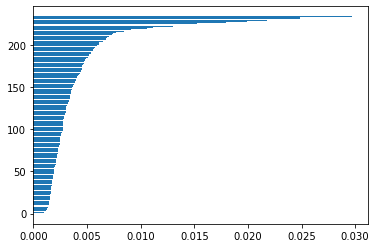

In [33]:
# Calculate & plot Feature importance 
importance = list(classifier.feature_importances_)
importance.sort()

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.show()

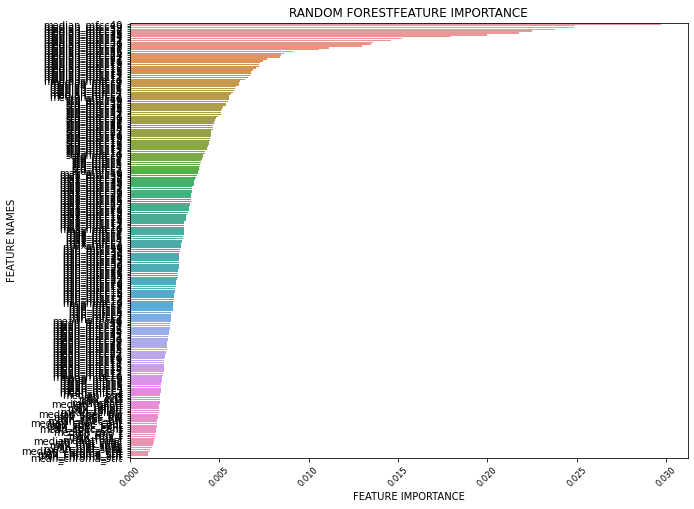

In [34]:
# Calculating and plotting feature importance

def plot_feature_importance(importance,names,model_type):

                #Create arrays from feature importance and feature names
                feature_importance = np.array(importance)
                feature_names = np.array(names)

                #Create a DataFrame using a Dictionary
                data={'feature_names':feature_names,'feature_importance':feature_importance}
                fi_df = pd.DataFrame(data)

                #Sort the DataFrame in order decreasing feature importance
                fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

                #Define size of bar plot
                plt.figure(figsize=(10,8))
                #Plot Searborn bar chart
                sn.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
                #Add chart labels
                plt.tick_params(axis='x', which='major', labelsize= 'small', rotation=45)
                plt.title(model_type + 'FEATURE IMPORTANCE')
                plt.xlabel('FEATURE IMPORTANCE')
                plt.ylabel('FEATURE NAMES')


# calling function
plot_feature_importance(importance, features.columns,'RANDOM FOREST')


In [25]:
# Feature selection by feature importance of random forest classifier

#Selecting important features
sel = SelectFromModel(RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1))
sel.fit(X_train, y_train)
sel.get_support()#Returns array of boolean values with importance status

array([False,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
        True,  True, False,  True, False, False, False, False,  True,
       False,  True,  True,  True,  True, False, False,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
        True, False,

In [26]:
#Feature columns
X_train.columns

Index(['mean_chroma_stft', 'min_chroma_stft', 'max_chroma_stft',
       'std_chroma_stft', 'median_chroma_stft', 'mean_mel_spec',
       'min_mel_spec', 'max_mel_spec', 'std_mel_spec', 'median_mel_spec',
       ...
       'median_mfcc31', 'median_mfcc32', 'median_mfcc33', 'median_mfcc34',
       'median_mfcc35', 'median_mfcc36', 'median_mfcc37', 'median_mfcc38',
       'median_mfcc39', 'median_mfcc40'],
      dtype='object', length=235)

In [27]:
#retained features
retained = X_train.columns[sel.get_support()]
retained

Index(['min_chroma_stft', 'std_chroma_stft', 'mean_mel_spec', 'max_mel_spec',
       'std_mel_spec', 'median_mel_spec', 'mean_rms_f', 'min_rms_f',
       'max_rms_f', 'std_rms_f', 'median_rms_f', 'mean_spec_bw', 'max_spec_bw',
       'std_spec_bw', 'max_rolloff', 'std_rolloff', 'mean_zcrf', 'mean_mfcc1',
       'mean_mfcc3', 'mean_mfcc4', 'mean_mfcc5', 'mean_mfcc6', 'mean_mfcc9',
       'mean_mfcc16', 'mean_mfcc17', 'mean_mfcc21', 'mean_mfcc22',
       'mean_mfcc25', 'mean_mfcc27', 'mean_mfcc31', 'mean_mfcc35',
       'mean_mfcc38', 'min_mfcc1', 'min_mfcc10', 'min_mfcc11', 'min_mfcc16',
       'min_mfcc21', 'min_mfcc22', 'min_mfcc25', 'min_mfcc31', 'min_mfcc38',
       'max_mfcc1', 'max_mfcc4', 'max_mfcc6', 'max_mfcc9', 'max_mfcc12',
       'max_mfcc27', 'std_mfcc6', 'std_mfcc7', 'std_mfcc8', 'std_mfcc9',
       'std_mfcc10', 'std_mfcc11', 'std_mfcc12', 'std_mfcc13', 'std_mfcc30',
       'median_mfcc1', 'median_mfcc3', 'median_mfcc4', 'median_mfcc9',
       'median_mfcc10', 'median_mfc

In [28]:
#Number of retained features
len(retained)

67

In [29]:
# overall mean importance of selected features
print(np.mean(sel.estimator_.feature_importances_))

#features above the mean importance carry more weight
sel.estimator_.feature_importances_

0.00425531914893617


array([0.00317789, 0.00582215, 0.        , 0.00624637, 0.00335784,
       0.02563976, 0.        , 0.0131036 , 0.01416632, 0.01428217,
       0.02610995, 0.00445494, 0.03388055, 0.02095587, 0.02202008,
       0.00295688, 0.00211809, 0.00150489, 0.00361897, 0.00295196,
       0.00452034, 0.00222914, 0.00763624, 0.00773296, 0.00391324,
       0.00242954, 0.00250929, 0.00484314, 0.02487001, 0.00232879,
       0.00517728, 0.0020366 , 0.00200624, 0.00257791, 0.00368442,
       0.01701688, 0.00401844, 0.00670879, 0.00924138, 0.00448557,
       0.00575374, 0.00318999, 0.00209093, 0.00528719, 0.0037636 ,
       0.00362874, 0.00359608, 0.00154359, 0.0037101 , 0.00284939,
       0.00592164, 0.00431199, 0.0022809 , 0.00295508, 0.00234356,
       0.00530813, 0.01043517, 0.00311605, 0.00231362, 0.00500316,
       0.00351779, 0.00584788, 0.00180217, 0.00347934, 0.00334648,
       0.00642449, 0.00184653, 0.00219541, 0.00337501, 0.00501063,
       0.00336967, 0.00191611, 0.00556878, 0.00308025, 0.00150

In [30]:
#function to call alogarithm for RandomForest
def run_randomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=35, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))

In [31]:
%%time
#Calling function on untrimmed dataset

run_randomForest(X_train, X_test, y_train, y_test)

[[2251    2]
 [  69  201]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2253
           1       0.99      0.74      0.85       270

    accuracy                           0.97      2523
   macro avg       0.98      0.87      0.92      2523
weighted avg       0.97      0.97      0.97      2523

Accuracy: 0.9718588981371383
Wall time: 1.09 s


In [32]:
%%time

X_train_rfc = sel.transform(X_train)
X_test_rfc = sel.transform(X_test)

#Calling function on trimmed dataset (with selected features)
run_randomForest(X_train_rfc, X_test_rfc, y_train, y_test)

[[2248    5]
 [  61  209]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2253
           1       0.98      0.77      0.86       270

    accuracy                           0.97      2523
   macro avg       0.98      0.89      0.92      2523
weighted avg       0.97      0.97      0.97      2523

Accuracy: 0.9738406658739596
Wall time: 822 ms


In [ ]:
#Random Forest unscaled, SVC unscaled

In [36]:
#create overall dataframe 

#Append target to features dataframe
new_df = pd.concat([features, y], axis=1)

#Adding column 'machine ID' (pump = 4)
new_df['Machine_ID'] = 4
new_df


#CSV of dataFrame

def createCsv(df):
    

    df.to_csv('martin_pump40.csv', index=False)
    
createCsv(new_df)

In [ ]:

# some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded